# Notebook for texture synthesis for MNIST

In [1]:
from synthesis_mnist import *

import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

# Define the transform to convert the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts image to PyTorch tensor
])

# Load the MNIST dataset
mnist_train = MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = MNIST(root='./data', train=False, download=True, transform=transform)


DATASET_IMAGES = 10000

# DataLoader
train_loader = DataLoader(mnist_train, batch_size=DATASET_IMAGES, shuffle=True)
# test_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)
 
# Move the data to the specified device (GPU 0)
training_images, training_labels = next(iter(train_loader))
# training_images = training_images.view(DATASET_IMAGES,28,28)


### Define input args

In [2]:
import datetime

window_size=(28,28)         # Generated image size, (height,width)
kernel_size=9                 # history window size
visualize=False

Synthesis finished. Time used: 3.6s


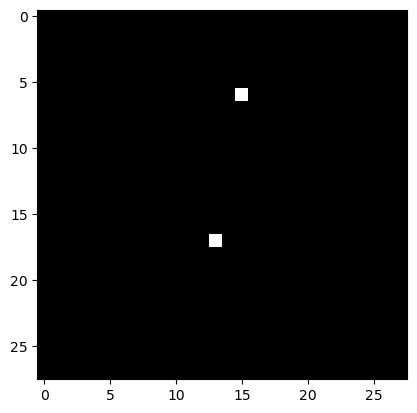

In [9]:

synthesized_texture = synthesize_texture(original_sample=training_images, 
                                            window_size=window_size, 
                                            kernel_size=kernel_size, 
                                            visualize=visualize)
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%m-%d_%H:%M:%S")  # Format: month-day hour:minute
out_path=f'outputs/mnist/{formatted_time}.png'
# print(synthesized_texture.shape)

plt.imshow(synthesized_texture.to('cpu').numpy(), vmin=0, vmax=1, cmap='grey')


In [4]:
import cv2
cv2.imwrite(out_path, synthesized_texture.to('cpu').numpy())

True